<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../../../Index.ipynb" target="_blank"><< Index</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 European Union <br>
**License:** MIT <br>
**Authors:** Vinca Rosmorduc (CLS), Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT)

<html>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies"><img src="https://img.shields.io/badge/open-EUMETLAB-E67E22.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://user.eumetsat.int/data/themes/marine"><img src="https://img.shields.io/badge/open-USER PORTAL-154360.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fapplications%2Focean-case-studies/HEAD?labpath=Case_studies%2FMaritime_safety%2FTopography_SWH%2FLand_altimetry_SWH.ipynb"><img src="https://mybinder.org/badge_logo.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4oceans/ocean-case-studies/Case_studies/Maritime_safety/Topography_SWH/Land_altimetry_SWH.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://code.insula.destine.eu/hub/"><img src="https://img.shields.io/badge/launch-DestinE-f43fd3.svg"></a></div></div>
</html>

<div class="alert alert-block alert-success">
<h3>Ocean case studies</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

This notebook has the following prerequisites:
- **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to download data from the EUMETSAT Data Store
    
There are no prerequisite notebooks for this module, but you may wish to look at the following notebooks on using SRAL data; <br>
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-SRAL" target="_blank">Learn SRAL (EUMETSAT Gitlab)</a>**
</div>
<hr>

# Linking land topography with altimetry derived winds and significant wave height

### Data used

| Dataset | EUMETSAT Data Store<br>collection ID | EUMETSAT collection<br>description | WEkEO dataset ID | WEkEO description |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SRAL level-2 | EO:EUM:DAT:0415 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:SENTINEL-3:SR_2_WAT___NTC" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-3:SR_2_WAT___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASR_2_WAT___" target="_blank">Description</a>|

### Learning outcomes

At the end of this notebook you will know;
* how to download data from the EUMETSAT Data Store using the **eumetsat data access (eumdac)** client
* how to plot altimetry derived winds and significant wave height in context with coastal topography
* how to compare altimetry products with data from other sources, such as Sentinel-1

### Outline

Winds are blowing over continents & islands, but are impacted by reliefs and this can be seen in ocean altimetry data. A North Atlantic storm mid-January 2023 crossed South-West France/North Spain into the Mediterranean Sea, winds blowing all the way and over the Sea again. It reached the Mediterranean waters early on 2023/01/18.

<div class="alert alert-info" role="alert">

## <a id='TOCTOP'></a>Contents

</div>

 1. [Step 1: Setting up our analysis](#section1)   
 1. [Step 2: Downloading altimetry products from the EUMETSAT Data Store](#section2)
 1. [Step 3: Plotting altimetry derived significant wave height and winds](#section3)
 1. [Step 4: Comparing with Sentinel-1 SAR wind data](#section4)

<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting up our analysis
[Back to top](#TOCTOP)

</div>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../../../README.md" target="_blank">README</a>**.

In [1]:
import os                              # a library that allows us access to basic operating system commands
import eumdac                          # a tool that helps us download via the eumetsat/data-store
import datetime                        # a library that allows us to work with dates and times
import shutil                          # a library that allows us access to basic operating system commands like copy
import zipfile                         # a library that support zipping/unzipping files
import xarray                          # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib                      # a library the provides plotting capability
import matplotlib.pyplot as plt        # a library the provides plotting capability
import cartopy.crs as ccrs             # a library that supports mapping and projection
import cartopy.io.img_tiles as cimgt   # a subcomponent of cartopy that plots land tiles
import numpy as np                     # a library that lets us work with arrays; we import this with a new name "np"
from pathlib import Path               # a library that helps construct system path objects
import getpass                         # a library to help us enter passwords
import warnings                        # a library that supports managing warning messages

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 16})

We are going to study an area north-west of the Mediterranean Sea, along the French and Spanish coasts, including the Balearic Island. 

In this section of the notebook we will select and acquire some Sentinel-3 SAR Radar Altimeter (SRAL) data that is relevant to our region of interest (ROI). Lets begin by defining the bounds of this region, converting them into a well known text (WKT) format polygon that describes the list of the corners of a box.

Along with this, we will also define our time range of interest.

In [2]:
# defining our bounding box
lon_min = 0
lon_max = 5
lat_min = 35
lat_max = 45

# make a WKT polygon string for this box
roi = [[lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min], [lon_min, lat_min], [lon_min, lat_max]]
polygon = 'POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi]))

# defining out search times; we will look only in the morning (00:01 to 13:00 UTC)
start = datetime.datetime(2023, 1, 18, 1, 0)
end = datetime.datetime(2023, 1, 18, 12, 0)

Next we will define directory to download our SRAL products into. By default we will set this to a directory called "products" that is in the same folder as this notebook.

In [3]:
# Create a download directory for our products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Downloading altimetry products from the EUMETSAT Data Store
[Back to top](#TOCTOP)

</div>

<div class="alert alert-block alert-success">

### Accessing the EUMETSAT Data Store

To access Copernicus marine data from the <a href="https://data.eumetsat.int " target="_blank">EUMETSAT Data Store</a>, we will use the EUMETSAT Data Access Client (`eumdac`) python package. If you are working with the recommended Anaconda Python distribution and used the environment file included in this repository (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

You can also find the source code on the <a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac " target="_blank">EUMETSAT GitLab</a>. Please visit the EUMETSAT user portal for more information on the <a href="https://user.eumetsat.int/data-access/data-store " target="_blank">EUMETSAT Data Store</a> and <a href="https://user.eumetsat.int/resources/user-guides/eumetsat-data-access-client-eumdac-guide " target="_blank">eumdac</a>.

To download data from the EUMETSDAT Data Store via API, you need to provide credentials. To obtain these you should first register at for an <a href="https://eoportal.eumetsat.int/" target="_blank">EUMETSAT Earth Observation Portal account</a>. Once you have an account, you can retrieve your `<your_consumer_key>` and `<your_consumer_secret>` from the <a href="https://api.eumetsat.int/api-key/ " target="_blank">"EUMETSAT Data Store API"</a> page (*Note: you must click the "Show hidden fields" button at the bottom of the page to see the relevant fields*). If you do not already have a local credentials file, you will be prompted to enter your credentials when you run the cell below. This will create the required local credentials file, so that you only need to run this once.

*Note: your key and secret are permanent, so you should take care to never share them*

</div>

In [4]:
# load credentials
eumdac_credentials_file = Path(Path.home() / '.eumdac' / 'credentials')

if os.path.exists(eumdac_credentials_file):
    consumer_key, consumer_secret = Path(eumdac_credentials_file).read_text().split(',')
else:
    # creating authentication file
    consumer_key = input('Enter your consumer key: ')
    consumer_secret = getpass.getpass('Enter your consumer secret: ')
    try:
        os.makedirs(os.path.dirname(eumdac_credentials_file), exist_ok=True)
        with open(eumdac_credentials_file, "w") as f:
            f.write(f'{consumer_key},{consumer_secret}')
    except:
        pass
        
token = eumdac.AccessToken((consumer_key, consumer_secret))
print(f"This token '{token}' expires {token.expiration}")

This token 'cc52cc6d-5488-3c7e-9f86-578c171b4be8' expires 2025-06-11 15:18:47.852643


Now we have a token, we can create an instance of the EUMETSAT Data Store.

In [5]:
datastore = eumdac.DataStore(token)

Data in the Data Store are stored as collections, each with its own ID. If we don't know our collection ID *a priori*, we can find this information via the **<a href="https://data.eumetsat.int/">Data Store GUI</a>** or by asking `eumdac` to tell us about all available SRAL and Poseidon-4 collections as follows:

In [6]:
#list all SRAL and Poseidon-4 collection IDs - if we don't know a priori which satellite we are interested in. 
for collection_id in datastore.collections:
    if ("SRAL" in collection_id.title) or ("Poseidon-4" in collection_id.title):
        if "non-public" in collection_id.abstract: continue
        print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0142): Poseidon-4 Level 2P Wind/Wave Products Low Resolution in NRT - Sentinel-6
Collection ID(EO:EUM:DAT:0143): Poseidon-4 Level 3 Wind/Wave Products Low Resolution in NRT - Sentinel-6
Collection ID(EO:EUM:DAT:0406): SRAL Level 1B - Sentinel-3
Collection ID(EO:EUM:DAT:0413): SRAL Level 1A Unpacked L0 Complex echos - Sentinel-3
Collection ID(EO:EUM:DAT:0414): SRAL Level 1B stack echoes - Sentinel-3
Collection ID(EO:EUM:DAT:0415): SRAL Level 2 Altimetry Global - Sentinel-3
Collection ID(EO:EUM:DAT:0601): Poseidon-4 Level 3 Altimetry Low Resolution in NTC - Sentinel-6
Collection ID(EO:EUM:DAT:0850): Poseidon-4 Altimetry Level 1A High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0851): Poseidon-4 Altimetry Level 1B High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0852): Poseidon-4 Altimetry Level 1B Low Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0854): Poseidon-4 Altimetry Level 2 Low Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0855): Poseidon-

From the lists above, we will pick the "SRAL Level 2 Altimetry Global (version BC005) - Sentinel-3 - Reprocessed" collection ID (`EO:EUM:DAT:0834`). Note that it includes both Sentinel-3A & Sentinel-3B. Lets now get our collection....

In [7]:
collectionID = 'EO:EUM:DAT:0834'
selected_collection = datastore.get_collection(collectionID)

Now we have our collection of interest, we can refine our search to obtain **only** the products that match our criteria. Lets apply our search and list our results.

In [8]:
products = selected_collection.search(geo=polygon, dtstart=start, dtend=end)
for product in products:
    print(product)

S3B_SR_2_WAT____20230118T100419_20230118T105202_20230513T025400_2863_075_122______MAR_R_NT_005.SEN3


Depending on the time we have chosen we will have 1, 2 or 3 products, corresponding to;
* a near real time (NRT) product (*_NR_*) if we have chosen a very recent time
* a short time critical (STC) product (*_ST_*) if we have chosen a fairly recent time
* a non time-critical (NTC) product (*_NT_*) if we have chosen an older product

In time, both NRT and STC products are removed from the Data Store, and the corresponding NTC product is of a higher quality.

Lets download and unzip all our products, tidying up afterwards....

In [9]:
for product in products:
    selected_product = datastore.get_product(product_id=product, collection_id=collectionID)
    with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    # Unzip the product
    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(selected_product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {selected_product} finished.')
     # Clean up
    os.remove(fdst.name)
    print('------')

Download of product S3B_SR_2_WAT____20230118T100419_20230118T105202_20230513T025400_2863_075_122______MAR_R_NT_005.SEN3.zip finished.
Unzipping of product S3B_SR_2_WAT____20230118T100419_20230118T105202_20230513T025400_2863_075_122______MAR_R_NT_005.SEN3 finished.
------


If you look in these products you will notice that they containe three different files plus a manifest XML file. We can be more specific in our downloading using a number of different options, which we can show below.

In [10]:
selected_collection.search_options

{'bbox': {'title': 'Inventory which has a spatial extent overlapping this bounding box',
  'options': []},
 'geo': {'title': 'Inventory which has a spatial extent overlapping this Well Known Text geometry',
  'options': []},
 'title': {'title': 'Can be used to define a wildcard search on the product title (product identifier), use set notation as OR and space as AND operator between multiple search terms',
  'options': [None]},
 'sat': {'title': 'Mission / Satellite',
  'options': ['Sentinel-3A', 'Sentinel-3B']},
 'type': {'title': 'Product Type', 'options': ['SR_2_WAT___']},
 'dtstart': {'title': 'Temporal Start', 'options': []},
 'dtend': {'title': 'Temporal End', 'options': []},
 'publication': {'title': 'publication date', 'options': []},
 'zone': {'title': 'Equi7grid main continental zone',
  'options': ['AN', 'NA', 'AS', 'OC', 'EU', 'SA', 'AF']},
 't6': {'title': 'Equi7grid 600km tile', 'options': []},
 'timeliness': {'title': 'Timeliness', 'options': ['NT']},
 'orbit': {'title':

Further, to only download only one file in a product we can iterate through the product **entries** and choose to only download, for example, the "reduced" file, as shown below. We will also "prune" our downloads to only get the short time-critical product, using the `.timeliness` search option. 

In [11]:
for product in products:
    for entry in product.entries:
        if 'reduced_measurement.nc' in entry:
            with product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name), mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')

Download of file reduced_measurement.nc finished.


We now have all the SRAL data we need to proceed...

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Plotting altimetry derived significant wave height and winds
[Back to top](#TOCTOP)

</div>

Now we have our data, we can start to work with it. Lets start by opening our "reduced measurement" file. We will do this using the `xarray` package.

In [12]:
# select input file
input_file = os.path.join(download_dir, 'reduced_measurement.nc')

# open input file
ncalti = xarray.open_dataset(input_file)

Now lets read in the variables we want; our coordinates, flags, significant wave height and wind speed.

In [13]:
# load coordinates
lat = ncalti['lat_01']
lon = ncalti['lon_01']
lat_no_good = lat.copy()

# load flags
flags = ncalti['surf_class_01']

# load the data ; we take the Significant Wave Height field at 1 Hz in Ku band, SAR-mode (plrm would do, too), 
# over ocean surfaces.
swh = ncalti.variables['swh_ocean_01_ku']

# load the data ; we take the wind speed field at 1 Hz in Ku band, SAR-mode (plrm would do, too)
#wind_speed_alt_01_plrm_ku
winds = ncalti.variables['wind_speed_alt_01_ku']

We are going to apply our flag to our data. In this case, we are going to set all data to NaN where our 1Hz surface class (`surf_class_01`) has been determined to be non-zero, meaning not ocean. The only exception is the lat_no_good variable, to which we apply the inverse, so that we can indicate non-ocean in one of our plots later on.

In [14]:
lat_no_good[flags==0] = np.nan
lat[flags!=0] = np.nan
lon[flags!=0] = np.nan
swh[flags!=0] = np.nan
winds[flags!=0] = np.nan

Lets now close our measurement file.

In [15]:
ncalti.close()

We now have all the variables we need, so lets make some plots to see what they show. First of all, lets take a look at the significant wave height along our swath, adding a terrain map to give some context to the signal.

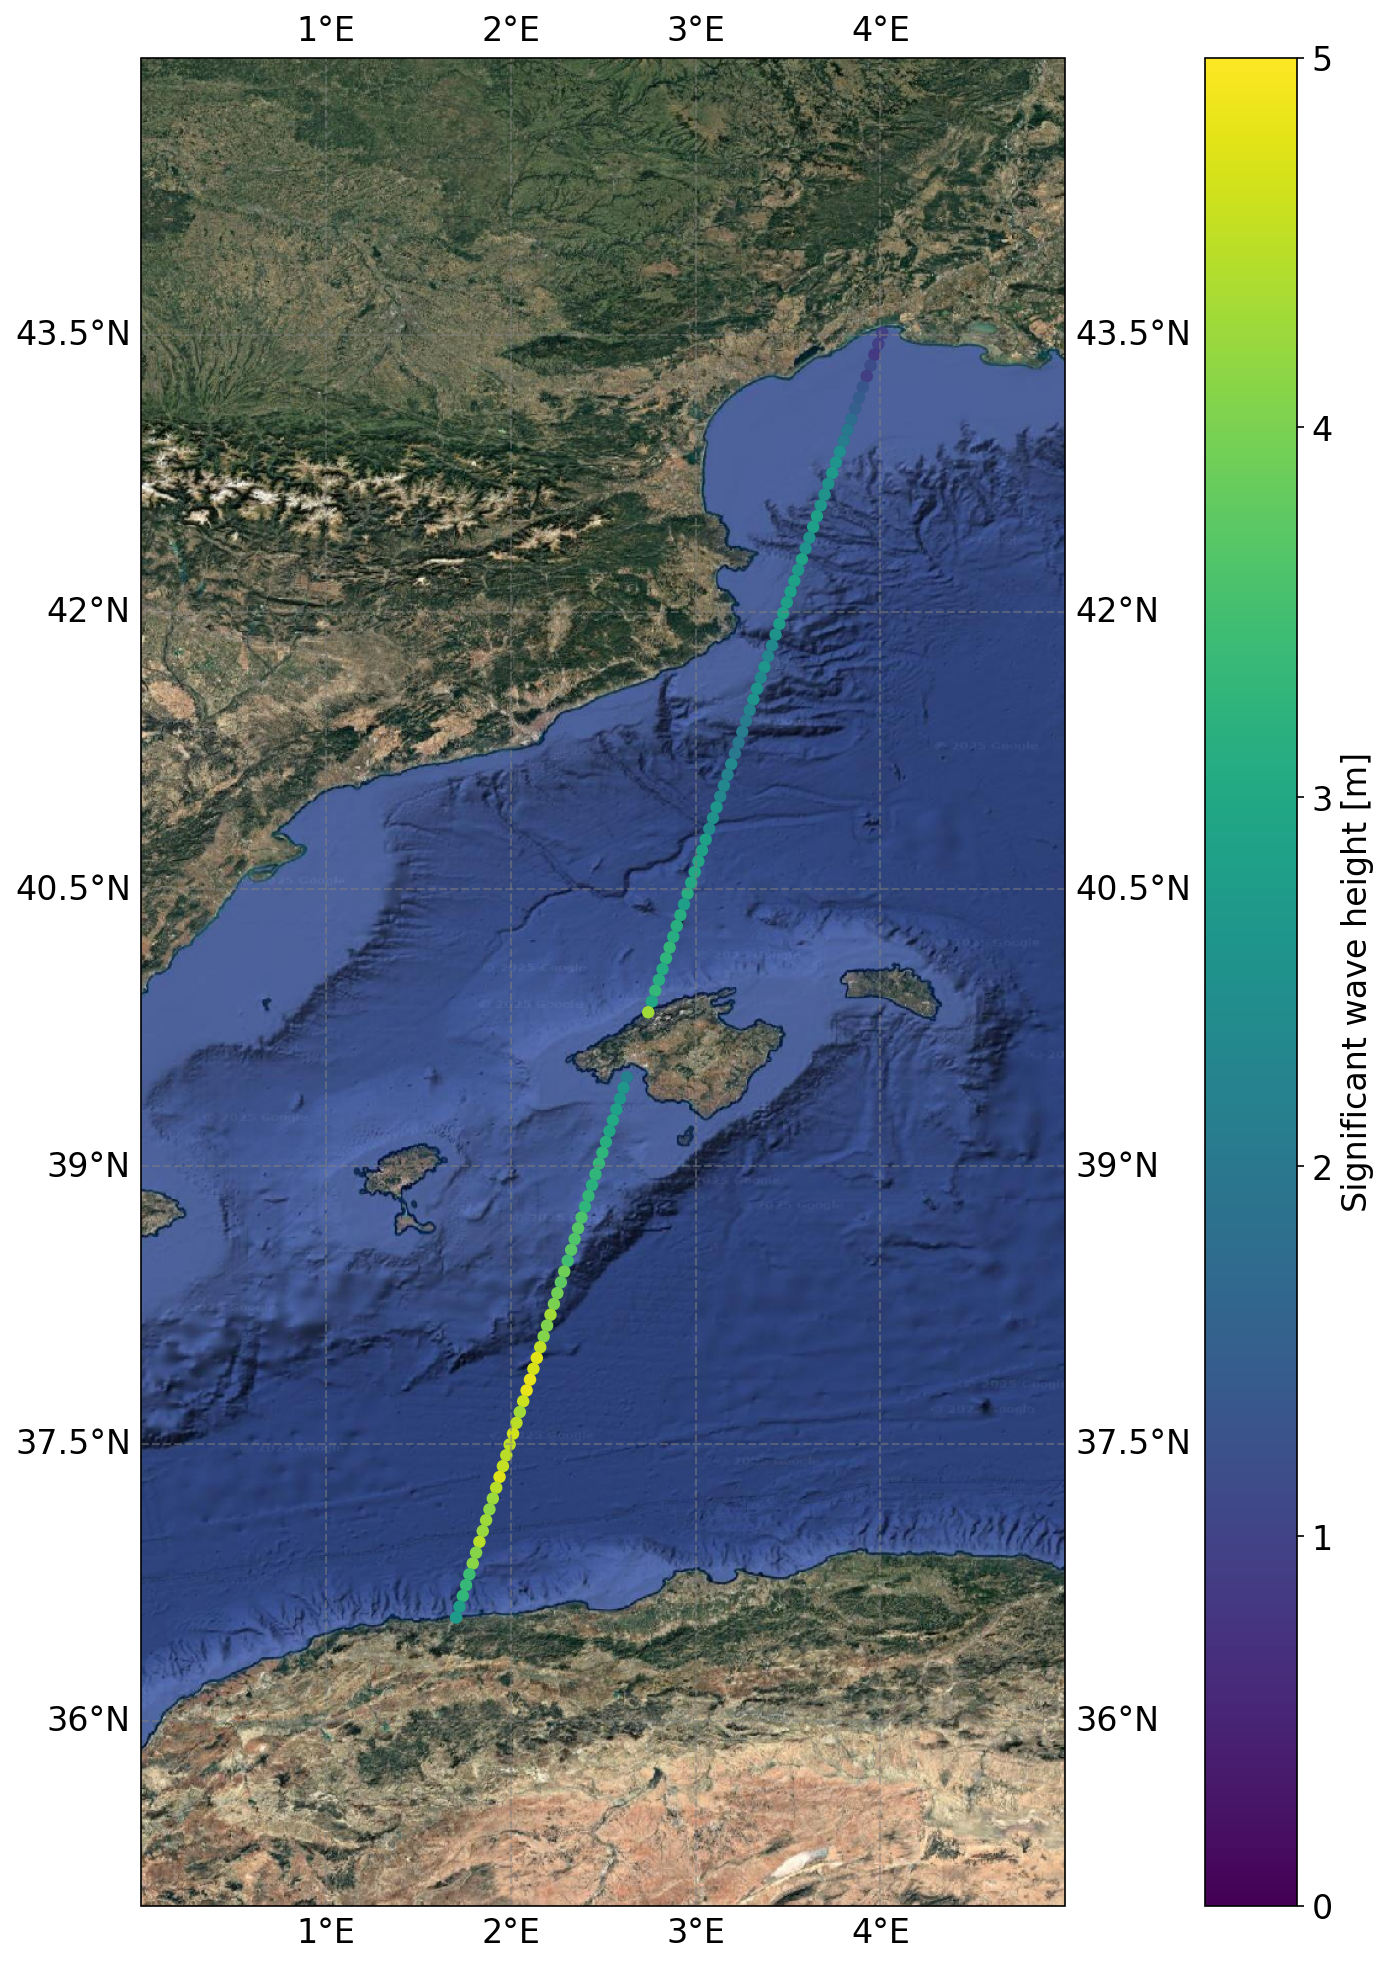

In [16]:
# make a figure
fig = plt.figure(figsize=(24,16), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

# decorate the figure
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# add the background
tiler = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')
ax.add_image(tiler, 8)

# plot and show the data
tracks = ax.scatter(lon, lat, c=swh,  vmin=0, vmax=5, cmap='viridis',
                    marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
cbar.set_label('Significant wave height [m]')
plt.show()

Winds are blowing to the east across southwest France coming from the Atlantic, and through Northern Spain. The waves are not very high close to the northern shore, a bit higher, then lower before crossing Mallorca; the highest waves are observed between Mallorca and Algeria. The two points closest to Mallorca seem to be erroneous and probably should be removed.

Next, lets take a look at the winds.

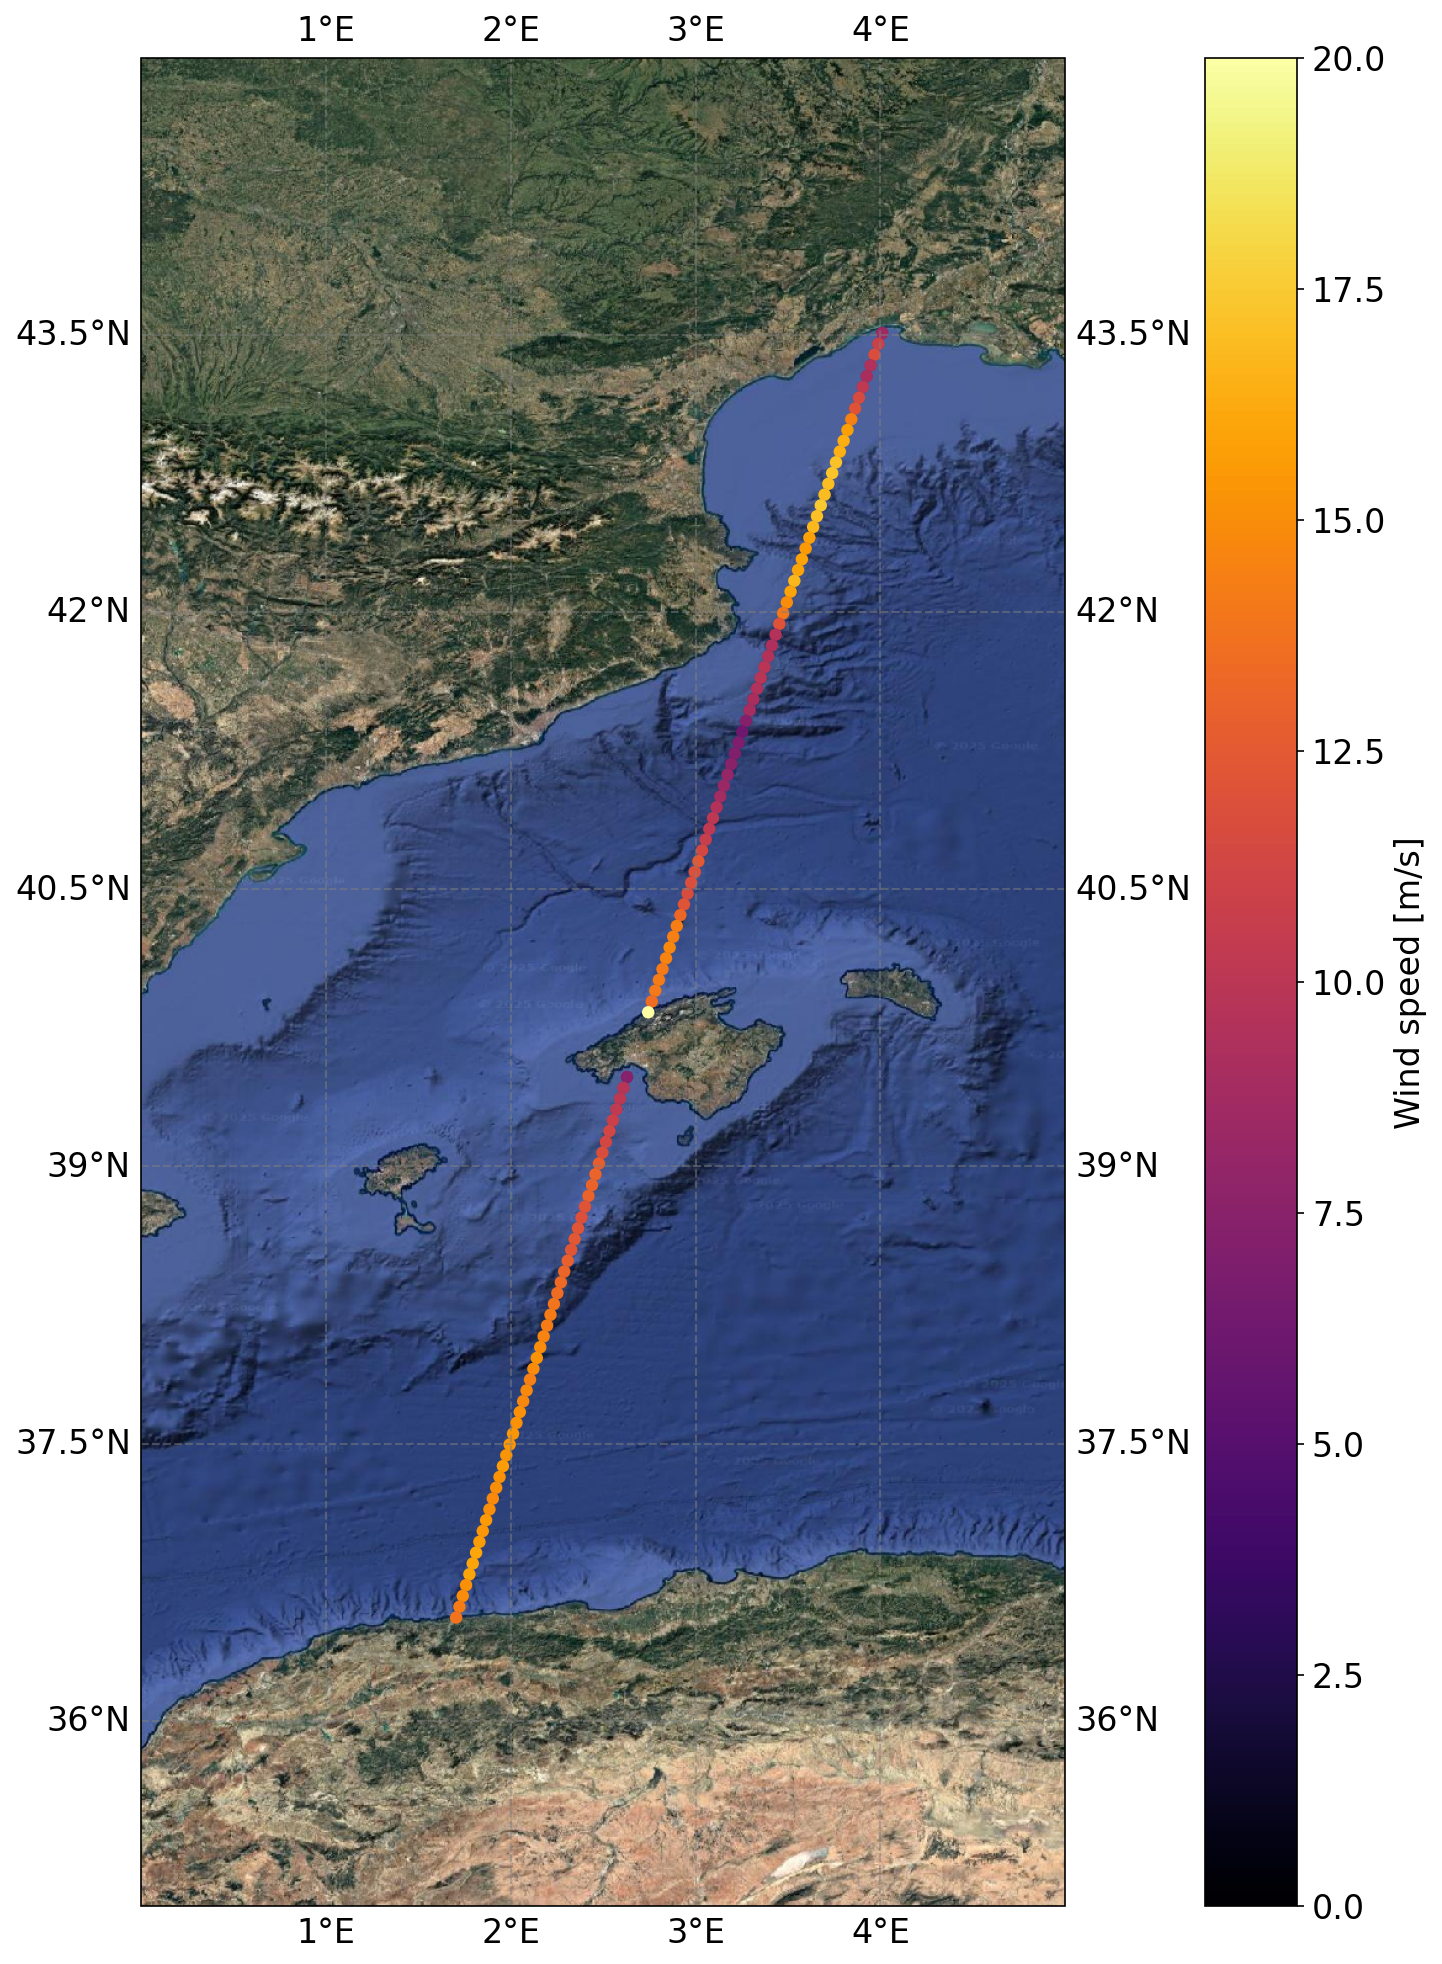

In [17]:
# make a figure
fig = plt.figure(figsize=(24,16), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

# decorate the figure
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# add the background
tiler = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')
ax.add_image(tiler, 8)

# plot and show the data
tracks = ax.scatter(lon, lat, c=winds,  vmin=0, vmax=20, cmap='inferno',
                    marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
cbar.set_label('Wind speed [m/s]')
plt.show()

The winds are higher on the northern part of the track, then lower South-east of the Pyrenees mountains, before being the highest close to Algeria. The lower values southeast of the Pyrenees is due to the wake of the mountains, which are shadowing the sea from the Atlantic winds blowing to the east.

Lets look at the data in a slightly different way, using latitude as the x-axis. The grey regions in this plot use our "lat_no_good" variable to show (amongst other things) the land regions or Algeria (left), Mallorca (middle) and France (right). Winds are in red, SWH in blue.

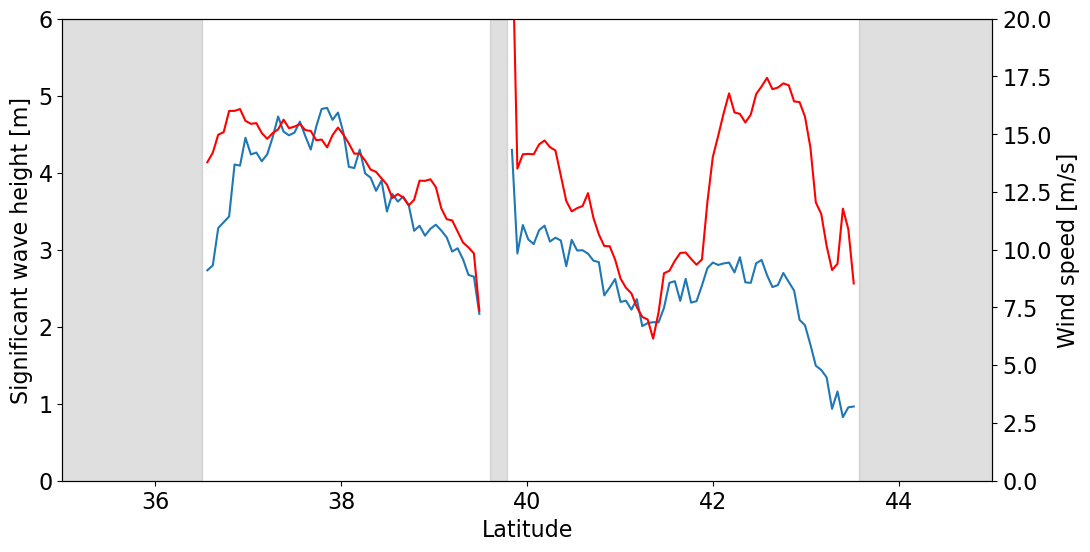

In [18]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.axes()
ax1.set_ylabel('Significant wave height [m]')
ax1.set_xlabel('Latitude')
ax1.axis([lat_min, lat_max, 0, 6])
ax1.plot(lat, swh)
ax2 = ax1.twinx()
ax2.set_ylabel('Wind speed [m/s]')
ax2.axis([lat_min, lat_max, 0, 20])
ax2.plot(lat, winds, 'r')
ax2.fill_between(lat_no_good, 0, 20, color='0.5', alpha=0.25);

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Comparing with Sentinel-1 SAR wind data
[Back to top](#TOCTOP)

</div>


So far we have just looked at the along track wind data from SRAL altimeter, but there are other data sources that we can compare against. For example, extreme winds data are available through the SFTP data access section of the <a href="http://www.esa-cyms.org">ESA Cyclone Monitoring Service (CYMS)</a>. Below we will compare our SRAL track with Sentinel-1 SAR data at 5:53 UTC. Note that our altimeter data is from about 10:20 UTC, so more than 4 hours after the Sentinel-1 acquisition, giving the winds some time to change.

Lets open the Sentinel-1 file, which is included in the "precomputed" directory, and load in our variables of interest.

In [19]:
# select SAR file
sar_file = 'precomputed/s1a-iw-owi-cm-20230118t055303-20230118t055508-000003-046834_gs.nc'

# read in variables
ncsar = xarray.load_dataset(sar_file)
latsar = ncsar.variables['latitude'][0]
lonsar = ncsar.variables['longitude'][0]
windsar = ncsar.variables['wind_speed'][0]
ncsar.close()

Now lets overlay our track on the Sentinel-1 wind speed field.

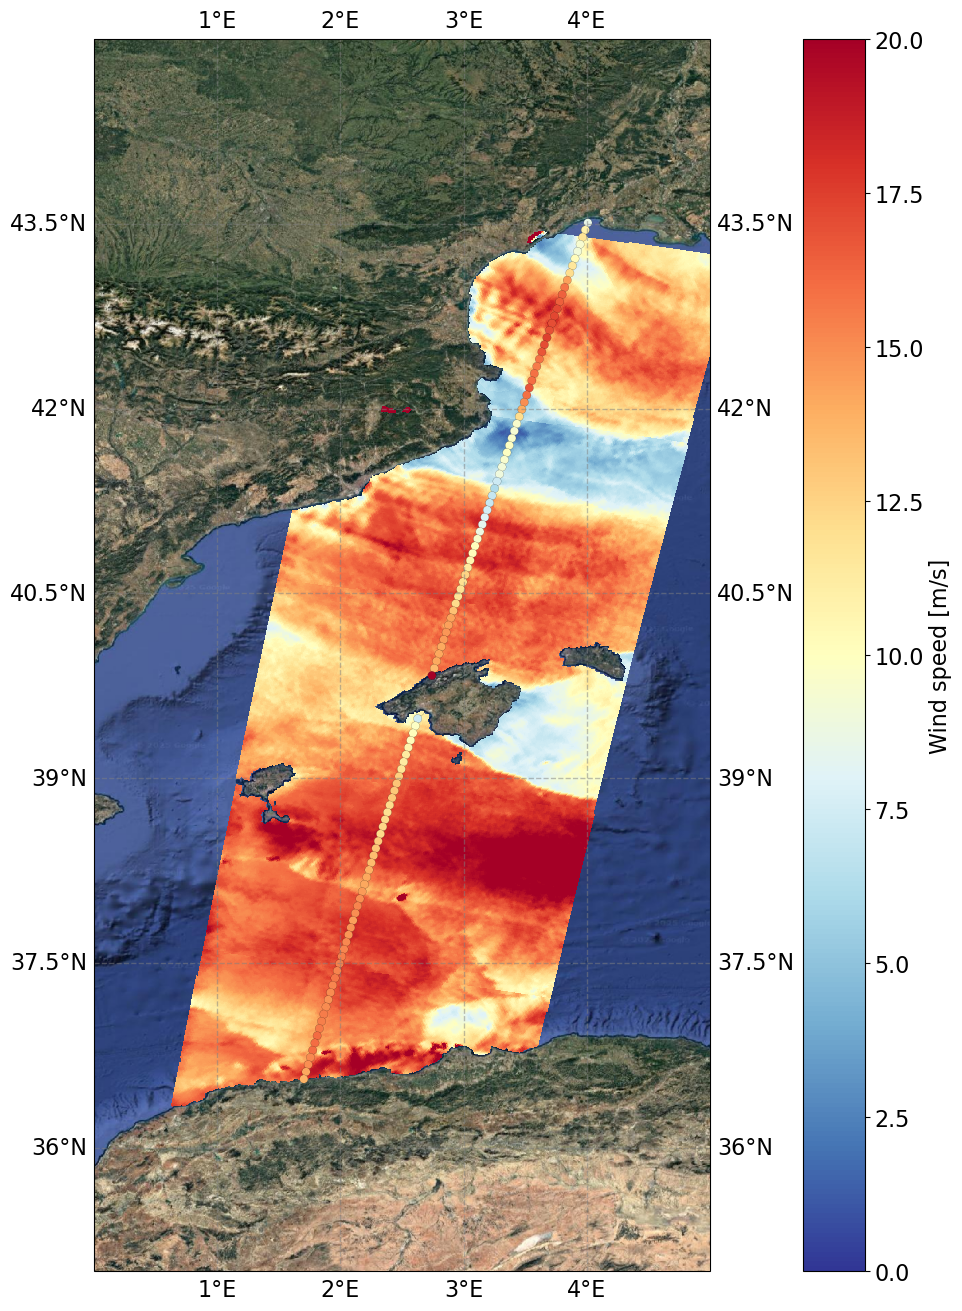

In [20]:
# make a figure
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())

# decorate the figure
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# add the background
tiler = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')
ax.add_image(tiler, 8)

# plot and show the data
mymap = ax.pcolor(lonsar, latsar, windsar, vmin=0, vmax=20, cmap='RdYlBu_r')
tracks = ax.scatter(lon, lat, c=winds,  vmin=0, vmax=20, cmap='RdYlBu_r',
                    marker='o', edgecolors='black', linewidth=0.1)
cbar = plt.colorbar(mymap)
cbar.set_label('Wind speed [m/s]')
plt.show()

The shadowing of the Pyrénées mountains from the winds is visible in this image, which also shows the Mallorca island wake. The island wake is not visible in our Sentinel-3B track, or any other nearby Sentinel-3 track (either A or B). However, it can be seen in another altimetry satellite (HY-2B) a bit further East.

The two wind data products from Sentinel-3B and Sentinel-1A SAR do not exactly match. The altimeter wind northermost high and low are slightly shifted to the South, likely due to the ~4 hours between the two measurements, but there is broad agreement between the two.

<hr>
<a href="../../../Index.ipynb" target="_blank"><< Index</a>
<hr>

<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>